In [ ]:
#Montando Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta a tu dataset en Drive (ajústala según tu carpeta)
data_dir = "/content/drive/MyDrive/dataset"

Mounted at /content/drive


In [ ]:
#Detección y Recorte Facial con OpenCV
import cv2
import os

# Ruta de salida
output_dir = "/content/drive/MyDrive/dataset_cropped"
os.makedirs(output_dir, exist_ok=True)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for person in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person)
    output_person_path = os.path.join(output_dir, person)
    os.makedirs(output_person_path, exist_ok=True)

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            face = img[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (128, 128))  # estándar 128x128
            cv2.imwrite(os.path.join(output_person_path, img_name), face_resized)


In [ ]:
#Normalización de píxeles
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza píxeles
    validation_split=0.15  # 15% para validación
)


In [ ]:
#Aumento de Datos (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

In [ ]:
#División en Conjuntos
train_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 125 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


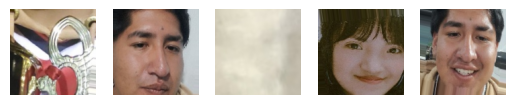

In [ ]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


In [7]:
#Importar librerías y preparar datos
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ruta al dataset recortado y normalizado
data_dir = "/content/drive/MyDrive/dataset_cropped"

# Generadores de entrenamiento y validación
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 125 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


In [8]:
#Cargar MobileNetV2 preentrenada (ImageNet)
# Cargamos la red base sin la parte superior (fully-connected)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)
base_model.trainable = False  # Congelamos capas base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
#Construir la red final (añadiendo nuestras capas)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Compilamos el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
EPOCHS = 20

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4357 - loss: 1.3650 - val_accuracy: 0.5238 - val_loss: 0.9845
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.6313 - loss: 0.8550 - val_accuracy: 0.5714 - val_loss: 0.7668
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 610ms/step - accuracy: 0.8492 - loss: 0.4161 - val_accuracy: 0.6667 - val_loss: 0.7436
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step - accuracy: 0.7958 - loss: 0.4012 - val_accuracy: 0.6667 - val_loss: 0.6866
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.9450 - loss: 0.1883 - val_accuracy: 0.7143 - val_loss: 0.5671
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 0.9408 - loss: 0.2242 - val_accuracy: 0.7619 - val_loss: 0.5285
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.9555 - loss: 0.1398 - val_accuracy: 0.7619 - val_loss: 0.5299
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step - accuracy: 0.9571 - loss: 0.1252 - val_accuracy: 0.7619 - val_loss: 0

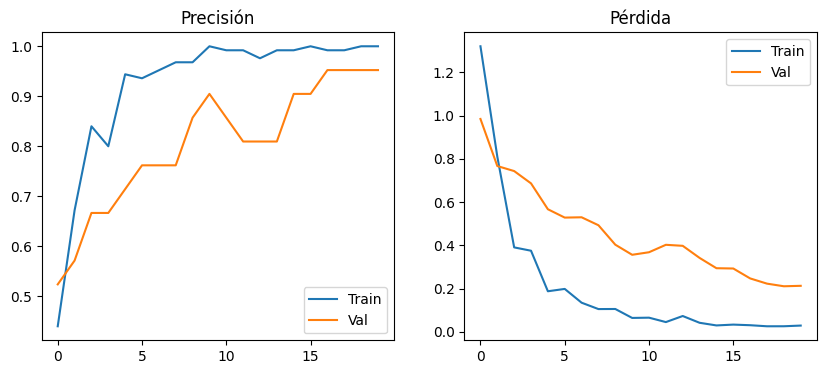

In [11]:
#Visualizar métricas de entrenamiento
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Precisión')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Pérdida')
plt.legend()
plt.show()


In [12]:
#Guardar el modelo entrenado
model.save('/content/drive/MyDrive/FaceID_Model/mobilenet_faceid.h5')
